In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def Majew(gamma, alpha, kappa1, beta, Lambda, stdv):
    
    Epsilon=np.random.normal(0, stdv, (length,nb))
    v=np.zeros((length,nb))
    m=np.zeros((length,nb))
    
    # We initialize the different functions we will need
    
    p=np.ones((length,nb))
    
    # We initialize the price
    
    for t in range(1,length-1):
        
        v[t] = (1-Lambda)*v[t-1] + Lambda*p[t]
        
        m[t] = (1-alpha)*m[t-1] + alpha*(p[t]-p[t-1])
        
        p[t+1] = p[t] + kappa1*(v[t]-p[t]) + beta*np.tanh(gamma*m[t]) + Epsilon[t+1]
    
    return p

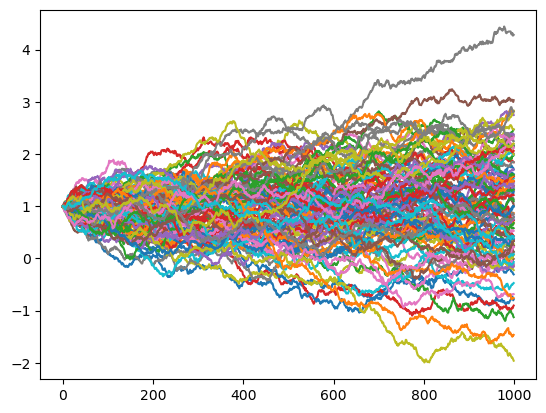

In [55]:
length, nb = 1000, 100
plt.plot(Majew(36.7, 1/7, 0.017, 0.013, 0.5, 0.020))